## Stacks batch 3 - notebook 1


I am going to rerun the stacks pipeline on both datasets with a stack depth of m = 3. \

However, I have to decide whether to (1) Not use Marine's correction script and specify an upper bound error rate for the stacks likelihood model, or (2) Use Marine's correction script. 

there are pros and cons to both: 

|-- stacks likelihood PRO---|---stacks likelihood CON---|
|:---------------------------:|:---------------------------:|
| low mismatch genotype rate from [simulation](http://www.evernote.com/l/AoqW-Fjzz_NJKbBw_cohu4QgDNkdA5bx2lM/)|Fis inflated|

+Fis inflation: Charlie did a series of barplots that show that whether the error rate is set to 0.001 or 0.01, the Fis is always about 20-50% greater than the Fis that is produced using Marine's genotyping script. 

<br>

|-- MB correction PRO---|---MB correction CON---|
|:---------------------------:|:---------------------------:|
| high mismatch genotype rate from [simulation](http://www.evernote.com/l/AoqW-Fjzz_NJKbBw_cohu4QgDNkdA5bx2lM/)|trust genotypes more|

+high mismatch genotype rate: corrected average of 7.8% difference


<br>
<br>
**So what it really boils down to is: Is it more important to have the m3 genotypes be similar to the m10 genotypes, or is it more important to not undercall heterozygotes????**


Luckily I can just set the error rate now, and worry about working with Marine's script later.


### Choosing an error rate:

**Based on FIS differences between stacks and MB correction**

|-- error rate---|---difference between MB & Stacks Fis---|
|:---------------------------:|:---------------------------:|
|0.1|Stacks Fis 2x higher|
|0.05|Stacks Fis 6x higher|
|0.001|Stacks Fis 6-10x higher+|

+Fis from Marine's script looks a little sketchy on this one though; probably too low

Also note that at a stack depth of 3, Marine's script tends to call more heterozygotes than it does at a stack depth of 10. Stacks might perform better at lower stack depths?

<br>


**Based on replicate error rate**

In my Korean data, I ended up with around a 5% error rate for my replicates. However, I'm not entirely sure how much of that was lab error, so sequencing error is likely less than that.

<br>

**Other things to think about**

With very low error rates, the number of retained loci gets pretty low. 

|-- error rate---|---postMAF MB # loci---|---postMAF stacks # loci---|
|:---------------------------:|:---------------------------:|:---:|
|0.05|9192|7204|
|0.001|6759|2611|

When I simulate the stacks likelihood model, it seems like an error rate of 0.1 safely puts out a heterozygote with stack depths of 7 / 3 for each allele (magnitude of 10). With an error rate of 0.05, it safely puts out a heterozygote with a magnitude of 100.


<br>
** ERROR RATE CHOSEN: 0.05 **

<br>
#### 10/9/2017

### pstacks

In [1]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Compare-repo/notebooks'

In [2]:
cd ../scripts

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Compare-repo/scripts


In [5]:
!head pstacks_genShell_m3_10-9.py

###### Generate Shell Script to Run pstacks --> populations ######

## MF 3/10/2017
## For US Cod Data

## Edited by MF 5/3/2017 for Korea PCod Data
## Edited 6/25/2017 for Korea PCod Data
## Edited 10/9/2017 for combined data 




In [12]:
!python pstacks_genShell_m3_10-9.py \
PopMap_KOR.txt \
PopMap_AK_edit.txt

In [13]:
!head pstacks_batch3_10-9.sh

#!/bin/bash

#pstacks
pstacks -t sam -f ../../PCod-Korea-repo/stacks_b7_wgenome/PO010715_02.sam -o ../stacks_b3_wgenome -i 001 -m 3 -p 6 --model_type bounded --bound_high 0.05 2>> ../stacks_b3_wgenome/pstacks_out_b3_wgenome
pstacks -t sam -f ../../PCod-Korea-repo/stacks_b7_wgenome/PO010715_02_rep.sam -o ../stacks_b3_wgenome -i 002 -m 3 -p 6 --model_type bounded --bound_high 0.05 2>> ../stacks_b3_wgenome/pstacks_out_b3_wgenome
pstacks -t sam -f ../../PCod-Korea-repo/stacks_b7_wgenome/PO010715_04.sam -o ../stacks_b3_wgenome -i 003 -m 3 -p 6 --model_type bounded --bound_high 0.05 2>> ../stacks_b3_wgenome/pstacks_out_b3_wgenome
pstacks -t sam -f ../../PCod-Korea-repo/stacks_b7_wgenome/PO010715_06.1.sam -o ../stacks_b3_wgenome -i 004 -m 3 -p 6 --model_type bounded --bound_high 0.05 2>> ../stacks_b3_wgenome/pstacks_out_b3_wgenome
pstacks -t sam -f ../../PCod-Korea-repo/stacks_b7_wgenome/PO010715_08.1.sam -o ../stacks_b3_wgenome -i 005 -m 3 -p 6 --model_type bounded --bound_high 0.05 2>> ../s

In [14]:
cd ../

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Compare-repo


In [15]:
!mkdir stacks_b3_wgenome

In [ ]:
# run in directory
cd scripts
./pstacks_batch3_10-9.sh

<br>

#### 10/10/2017

### Does it look like lower stack depth helped the Alaskan samples?

**PARSE PSTACKS OUTPUT TO GET THE # LOCI, MEAN COVERAGE DEPTH**


In [1]:
cd ../

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Compare-repo


In [5]:
infile = open("stacks_b3_wgenome/pstacks_out_b3_wgenome", "r")
outfile = open("stacks_b3_wgenome/pstacks_nloci_depth.txt", "w")
outfile.write("sample\tn_loci\tmean_depth\n")

import collections
n_loci_dict = collections.OrderedDict()
mean_depth_dict = collections.OrderedDict()

for line in infile:
    if line.startswith("Parsing "):
        linelist = line.strip().split("/")
        sample = linelist[len(linelist)-1].strip(".sam")
    elif line.startswith("  Merged"):
        nloci = line.strip().split()[5]
        n_loci_dict[sample] = nloci
    elif line.startswith("  Mean coverage depth is"):
        depth = line.strip().split()[4].strip(";")
        mean_depth_dict[sample] = depth
infile.close()

for sample in n_loci_dict.keys():
    outfile.write(sample + "\t" + n_loci_dict[sample] + "\t" + mean_depth_dict[sample] + "\n")
outfile.close()

**PLOT KOREAN V. ALASKAN # LOCI, MEAN STACK DEPTHS**

In [6]:
infile = open("stacks_b3_wgenome/pstacks_nloci_depth.txt", "r")
header = infile.readline()

kor_nloci = []
ak_nloci = []
kor_depth = []
ak_depth = []
line = infile.readline()
while ("#") not in line:
    kor_nloci.append(int(line.strip().split()[1]))
    kor_depth.append(float(line.strip().split()[2]))
    line = infile.readline()
for line in infile:
    ak_nloci.append(int(line.strip().split()[1]))
    ak_depth.append(float(line.strip().split()[2]))
infile.close()

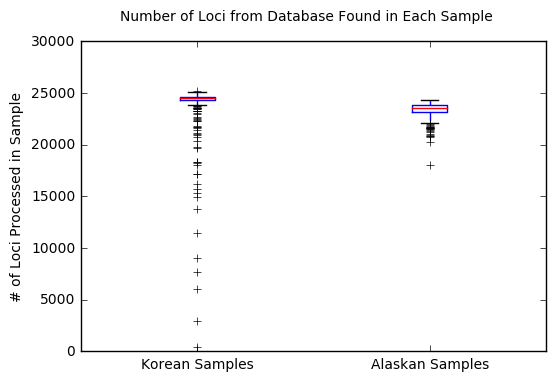

In [25]:
import numpy as np
import matplotlib.pyplot as plt
data= [kor_nloci, ak_nloci]
plt.boxplot(data, positions = [1,2], labels = ["Korean Samples", "Alaskan Samples"])
plt.suptitle("Number of Loci from Database Found in Each Sample")
plt.ylabel("# of Loci Processed in Sample")
plt.show()

In [26]:
plt.close()

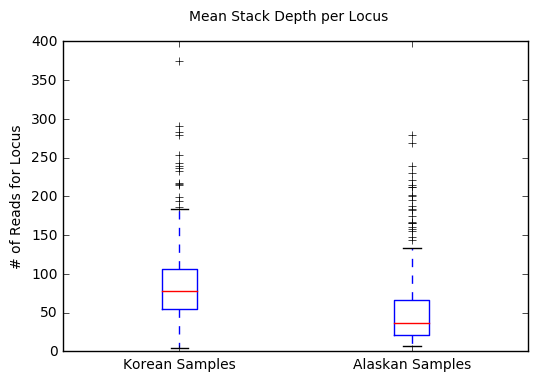

In [27]:
import numpy as np
import matplotlib.pyplot as plt
data= [kor_depth, ak_depth]
plt.boxplot(data, positions = [1,2], labels = ["Korean Samples", "Alaskan Samples"])
plt.suptitle("Mean Stack Depth per Locus")
plt.ylabel("# of Reads for Locus")
plt.show()

In [28]:
plt.close()

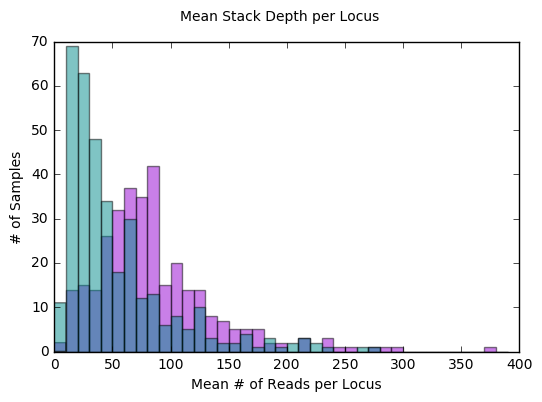

In [35]:
plt.hist(kor_depth, color = "darkviolet", alpha = 0.50, label = "Korean Samples", bins = np.arange(0,400,10))
plt.hist(ak_depth, color = "darkcyan", alpha = 0.50, label = "Alaskan Samples", bins = np.arange(0,400,10))
plt.suptitle("Mean Stack Depth per Locus")
plt.ylabel("# of Samples")
plt.xlabel("Mean # of Reads per Locus")
plt.show()

In [36]:
plt.close()

<br>
** Short Answer: I think so!**

### Choosing cstacks samples

To remove contaminated individuals, I used Alaskan information from batch 1. 

I began to redo the list of Korean samples, but as I went I found that many of the samples with the greatest # tags had the lowest # mapped reads in their `.sam` files. I suspect this means that they have many loci with very low read depths. I'll stick with the samples chosen from `batch 7` of the Korean samples. 

<br>

### cstacks --> populations

In [37]:
cd scripts

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Compare-repo/scripts


In [39]:
!head -n 15 pstacks_populations_genShell_m3_10-9.py

###### Generate Shell Script to Run pstacks --> populations ######

## MF 3/10/2017
## For US Cod Data

## Edited by MF 5/3/2017 for Korea PCod Data
## Edited 6/25/2017 for Korea PCod Data
## Edited 10/9/2017 for combined data - KOR and AK. DOES INCLUDE CSTACKS



## At Command Line: python cstacks_populations_genShell_m3_10-9.py ARG1 ARG2 ARG3
##---- ARG1 = samples for cstacks file (txt)
##---- ARG2 = Korea sample list file (population map)
##---- ARG3 = Alaska sample list file (population map)


In [41]:
!python pstacks_populations_genShell_m3_10-9.py \
samples_for_cstacks_combo_b3.txt \
PopMap_KOR.txt \
PopMap_AK_edit.txt

In [ ]:
#run in terminal
./cstacks_populations_batch3_10-9.sh

<br>
<br>
### Checking genepop

before I start the filtering steps, I want to see if I have a lot of missing data in the Alaskan samples. 

I do - ALOT of missing data. See below for the precise % of all loci + snp pairs that are missing data right out of `stacks`. 

In [1]:
cd ../

/mnt/hgfs/PCod-Compare-repo


In [2]:
infile = open("stacks_b3_wgenome/batch_3.genepop", "r")
infile.readline()
infile.readline()
n_pops = 0

kor_missing = []
ak_missing = []
for line in infile:
    if line.startswith("pop"):
        n_pops += 1
    else:
        genotypes = line.strip().split()[1:]
        n_total = len(genotypes)
        n_missing = len([i for i in genotypes if i == "0000"])
        proportion_missing = float(n_missing)/float(n_total)
        if n_pops <= 9:
            kor_missing.append(proportion_missing)
        elif n_pops > 9: 
            ak_missing.append(proportion_missing)
infile.close()

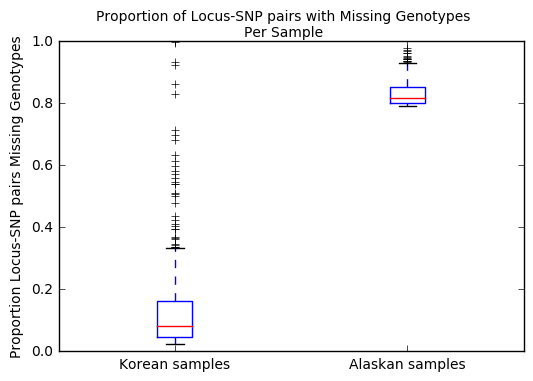

In [5]:
import numpy as np
import matplotlib.pyplot as plt
data = [kor_missing, ak_missing]
plt.boxplot(data, positions=[1,2], labels = ["Korean samples", "Alaskan samples"])
plt.suptitle("Proportion of Locus-SNP pairs with Missing Genotypes\nPer Sample")
plt.ylabel("Proportion Locus-SNP pairs Missing Genotypes")
plt.show()

In [6]:
plt.close()

<br>
Yikes. See [this notebook]() for troubleshooting.